<a href="https://colab.research.google.com/github/Akage1234/nn-zero-to-hero/blob/main/makemore/03_makemore_optimizations_batchnorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## --- Same code from previous notebook ---

In [77]:
!wget https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt -O names.txt

--2025-10-16 16:56:04--  https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2025-10-16 16:56:04 (14.3 MB/s) - ‘names.txt’ saved [228145/228145]



In [78]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [79]:
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [80]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [81]:
block_size = 3

def build_dataset(words):
    X, Y = [],[]
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [82]:
embed_dim = 10
n_hidden = 300
vocab_size = len(itos)

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, embed_dim), generator=g)
W1= torch.randn((embed_dim * block_size,n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

17697


In [83]:
n_iter = 200000
batch_size = 32
lossi = []

for i in range(n_iter):
    # mini batch contruct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10000==0:
        print(f'{i:7d}/{n_iter:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000:32.8991
  10000/ 200000:3.4133
  20000/ 200000:2.6286
  30000/ 200000:2.5110
  40000/ 200000:2.2597
  50000/ 200000:2.1035
  60000/ 200000:2.3200
  70000/ 200000:2.4409
  80000/ 200000:2.5763
  90000/ 200000:2.9274
 100000/ 200000:2.4649
 110000/ 200000:2.4505
 120000/ 200000:1.8379
 130000/ 200000:2.9544
 140000/ 200000:1.9633
 150000/ 200000:2.3902
 160000/ 200000:1.7216
 170000/ 200000:2.2968
 180000/ 200000:2.0695
 190000/ 200000:1.8086


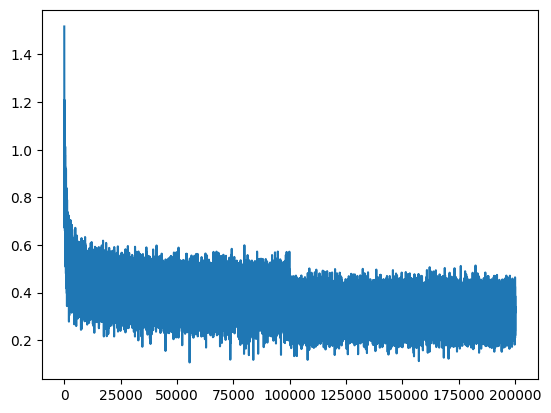

In [84]:
plt.plot(lossi)

In [85]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train':(Xtr, Ytr),
        'val':(Xval, Yval),
        'test': (Xtest, Ytest)
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1296091079711914
val 2.190476179122925


In [86]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        prob = F.softmax(logits, dim=1)
        ix = torch.multinomial(prob, num_samples=1, generator=g).item()
        context= context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carmahxa.
jahmerik.
mili.
thay.
salaysa.
jazhnel.
delyah.
jareen.
nellara.
chaiif.
kaleigh.
ham.
poin.
quint.
shon.
walianni.
watthoniearynix.
kaelissadi.
eddepiia.
gilee.


# Optimizing the model

*Notes:*
###**Optimization 1: Initial Loss**
The L-drop from the loss curve is caused by random weight initilization. More precisely, by randomly initializing the weights the probability distribution varies significantly for each individual character. Therefore the model spends first few iterations trying to adjust the weights to reasonable values. Resulting in the unreasonably high initial loss.

To optimize this we need to understand what causes initially unstable or skewed probability distribution

In [87]:
embed_dim = 10
n_hidden = 300
vocab_size = len(itos)

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, embed_dim), generator=g)
W1= torch.randn((embed_dim * block_size,n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

17697


In [88]:
n_iter = 200000
batch_size = 32
lossi = []

for i in range(n_iter):
    # mini batch contruct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10000==0:
        print(f'{i:7d}/{n_iter:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    break


      0/ 200000:28.0285


In [89]:
print(logits)

tensor([[-2.1255e+01, -3.5244e-01, -9.0889e-01, -3.9785e-01, -1.5482e+01,
          2.2185e+01, -1.1201e+01,  2.9861e+00,  1.7748e+01, -2.7588e+01,
         -6.0211e+00, -3.0121e+01,  2.1974e+00, -2.1778e+01,  2.6015e+01,
         -1.3265e+01, -7.4095e+00, -1.3814e+01,  3.6929e+01,  1.7905e+00,
         -3.4782e+01, -4.1902e+00,  2.4916e-01,  2.1842e+01, -1.3729e+00,
          2.2835e+00, -1.0017e+01],
        [-2.1936e+00,  9.7049e+00,  3.6926e+00, -2.0839e+01, -3.0287e+01,
          2.4644e+01, -1.2065e+01,  7.3139e+00,  2.6422e+01, -1.7098e+01,
          1.1755e+01,  1.4692e-01, -1.1451e+01, -1.9992e+01, -1.1148e+01,
         -3.1746e+00,  5.8148e+00, -1.8822e+01,  9.9854e+00, -2.6127e+01,
         -2.9510e+01, -1.8651e+00, -1.3605e+01,  2.2079e+01, -4.3780e+00,
          3.5710e+00,  1.4375e+01],
        [ 5.4854e+00, -4.6833e+00,  9.0414e+00,  9.9637e+00, -1.5816e+01,
         -2.5287e+01,  1.0348e+01, -2.3200e+01,  5.4762e+00,  1.0834e+01,
          3.7427e+01,  4.8338e+01, -2.01

We can see the logits take quite extreme values in first iteration. we can fix this in 2 ways:
1. Scaling down the weights w2 to keep them in reasonable range
2. keep b2 -> 0 instead of random values (Prevents unneccessary noise from start)

**Important:** why not 0 for w2 too? because initializing weights to 0 breaks symmetry, Every neuron is same at start. They recieve same info and produce same output. So the neurons stay identical forever and never learn distinct features. Then entire network or layer just acts same as one neuron would.

In [90]:
embed_dim = 10
n_hidden = 300
vocab_size = len(itos)

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, embed_dim), generator=g)
W1= torch.randn((embed_dim * block_size,n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

17697


In [91]:
n_iter = 200000
batch_size = 32
lossi = []

for i in range(n_iter):
    # mini batch contruct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10000==0:
        print(f'{i:7d}/{n_iter:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000:3.2919


Thats much closer to expected loss!

## Optimization 2: Tanh
Lets observe at hpreact and h distribution

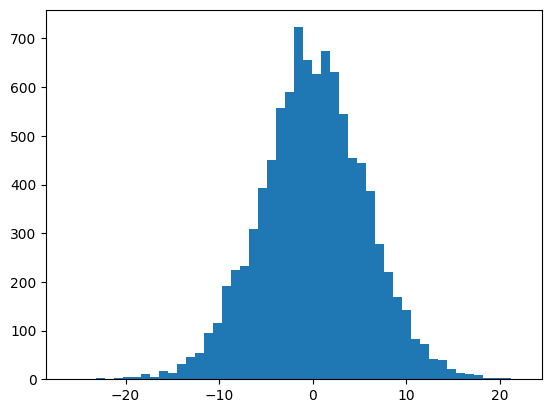

In [92]:
plt.hist(hpreact.view(-1).tolist(), bins=50);

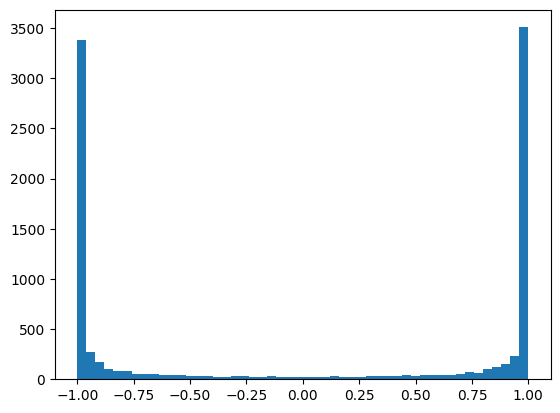

In [93]:
plt.hist(h.view(-1).tolist(), bins=50);

We can observe that Tanh is a squashing function, most of the values from hpreact gets squashed at tail ends (-1.0 and 1).
which means at backprop:
1 - t**2 * out.grad would give 0 at both 1 and -1 cases. killing most of the gradients. and letting other gradients pass as it is.
This, by itself, is not always a problem - It’s a natural behavior of tanh. But it can lead to problem to one called "Dead Neuron"

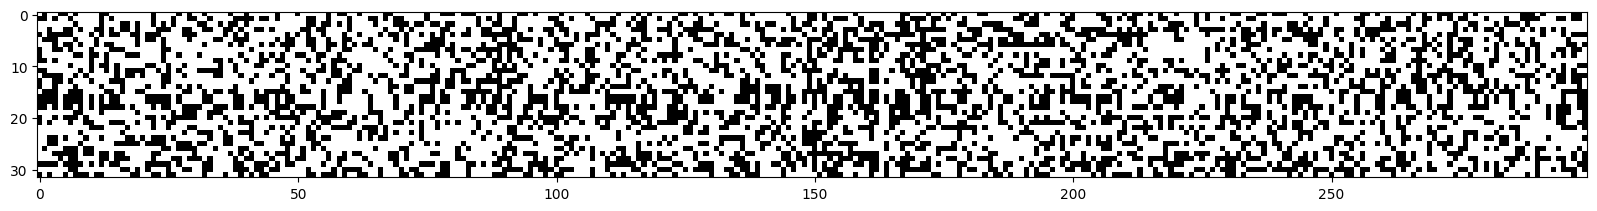

In [94]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

For this particular network we can see almost neurons gets activated at some point and learn. So its not an issue.

 However for more complex neurons the squashing from tanh might lead to vanishing gradients (gradients stay 0). The neurons stops learning and never activates, essentially making it dead neuron. Dead neurons can occur in cases where the learning rate is too high, the activation function has flat zones(sigmoid, tanh, relu). Its also possible during training that too many neurons gets into this state and the model stops learning. So its a very important factor to keep in mind while creating neural networks

Some Activation functions such as **LeakyReLU** doesnt face this problem often due to lack of flat surface.

###Fix:
Similar to the previous optimization, we need to make the hpreact distribution more balanced. To achieve this, we can scale down w1 and b1, ensuring that the activations stay within a reasonable range.

In [95]:
embed_dim = 10
n_hidden = 300
vocab_size = len(itos)

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, embed_dim), generator=g)
W1= torch.randn((embed_dim * block_size,n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

17697


In [96]:
n_iter = 200000
batch_size = 32
lossi = []

for i in range(n_iter):
    # mini batch contruct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10000==0:
        print(f'{i:7d}/{n_iter:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000:3.2997


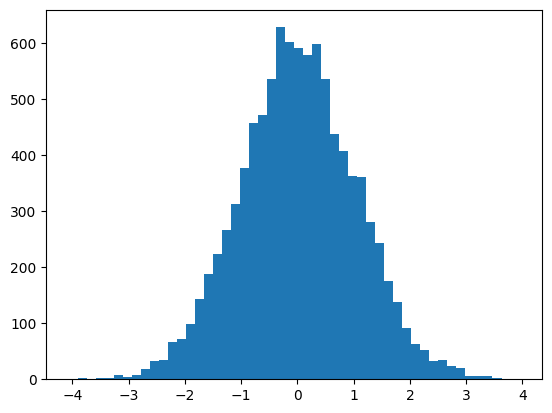

In [97]:
plt.hist(hpreact.view(-1).tolist(), bins=50);

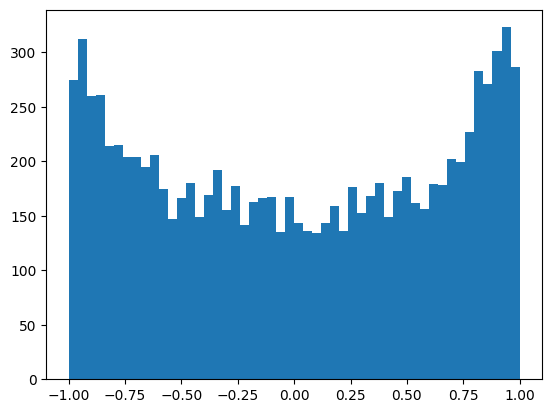

In [98]:
plt.hist(h.view(-1).tolist(), bins=50);

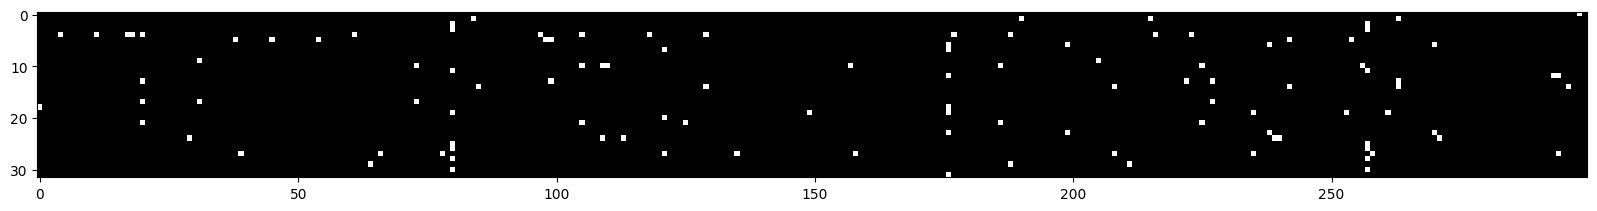

In [99]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

## **Optimization 3**

To prevent vanishing or exploding gradients, it’s important to keep the standard deviation of activations roughly the same across layers.

This can be achieved by scaling the weights by gain / sqrt(FanIn) during initialization, where FanIn is the number of input connections to the neuron. This ensures that the variance of activations stays stable across layers, allowing gradients to propagate effectively without shrinking to zero or blowing up.

In case of Tanh - gain of 5/3 is reconmended

In [100]:
embed_dim = 10
n_hidden = 300
vocab_size = len(itos)

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, embed_dim), generator=g)
W1= torch.randn((embed_dim * block_size,n_hidden), generator=g) * (5/3) / ((embed_dim * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

17697


This is called Kaiming/He initialization - one of the most commonly used initialization techniques. Pytorch uses kaiming initialization by default in Conv/Linear Layers.

# BatchNorm

Another approach we can utilize to ensure that the spread of data remains roughly gaussian throughout the network is through the use of **BatchNormalization**. Its usually used after Linear or Conv layers to normalize their outputs, keeping them approximately zero-mean and unit-variance

For smaller networks the improvement might not be much, but for deeper models with many layers and non linearities, batch normalization helps keep the gradients stable throughout the training and prevent them from vanishing/exploding

In [101]:
hpreact.shape

torch.Size([32, 300])

In [102]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 300])

In [103]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 300])

In [104]:
embed_dim = 10
n_hidden = 300
vocab_size = len(itos)

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, embed_dim), generator=g)
W1= torch.randn((embed_dim * block_size,n_hidden), generator=g) * (5/3) / ((embed_dim * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

# these will make sure at initialization the distribution is unit normal
bngain = torch.ones((1,n_hidden)) # scale factor
bnbias = torch.zeros((1,n_hidden))   # shift factor

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

18297


In [105]:
n_iter = 200000
batch_size = 32
lossi = []

for i in range(n_iter):
    # mini batch contruct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias     # batchnorm layer
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10000==0:
        print(f'{i:7d}/{n_iter:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000:3.2915


In [106]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train':(Xtr, Ytr),
        'val':(Xval, Yval),
        'test': (Xtest, Ytest)
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias     # batchnorm layer
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.2833199501037598
val 3.283778429031372


**Note:**  
Batch Normalization introduces a coupling between samples in the same batch — each activation now depends on the batch's mean and variance. This adds some randomness (entropy) to the training process, acting as a regularizer that makes overfitting harder.
However, this batch dependence can be undesirable, and while alternatives like LayerNorm or GroupNorm avoid it, BatchNorm remains popular because its regularization effect is so effective.

**Side effect:**
During training, the model learns to expect inputs normalized using the current batch’s mean and standard deviation. However, at inference time, we usually have a single sample (not a full batch), so these batch statistics are unavailable.

**Fix:**
To handle this, there are two common solutions:

***Fixed statistics:*** After training, compute the overall mean and standard deviation from the training data (or running averages) and use those fixed values during inference.

***Running (moving) averages:*** Maintain running estimates of the batch mean and variance during training (updated without gradient flow) and use these smoothed values at inference. This is generally the way its done to avoid extra computing after training.

In [107]:
embed_dim = 10
n_hidden = 300
vocab_size = len(itos)

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, embed_dim), generator=g)
W1= torch.randn((embed_dim * block_size,n_hidden), generator=g) * (5/3) / ((embed_dim * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

# these will make sure at initialization the distribution is unit normal
bngain = torch.ones((1,n_hidden)) # scale factor
bnbias = torch.zeros((1,n_hidden))   # shift factor
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

18297


In [108]:
n_iter = 200000
batch_size = 32
lossi = []

for i in range(n_iter):
    # mini batch contruct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias     # batchnorm layer
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi


    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10000==0:
        print(f'{i:7d}/{n_iter:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000:3.3062
  10000/ 200000:2.3146
  20000/ 200000:2.2146
  30000/ 200000:2.1039
  40000/ 200000:2.7904
  50000/ 200000:2.0544
  60000/ 200000:2.3553
  70000/ 200000:1.8879
  80000/ 200000:2.1551
  90000/ 200000:2.2664
 100000/ 200000:2.3527
 110000/ 200000:2.2948
 120000/ 200000:1.8107
 130000/ 200000:1.9829
 140000/ 200000:2.1292
 150000/ 200000:2.4506
 160000/ 200000:1.9433
 170000/ 200000:1.9699
 180000/ 200000:1.7770
 190000/ 200000:2.0792


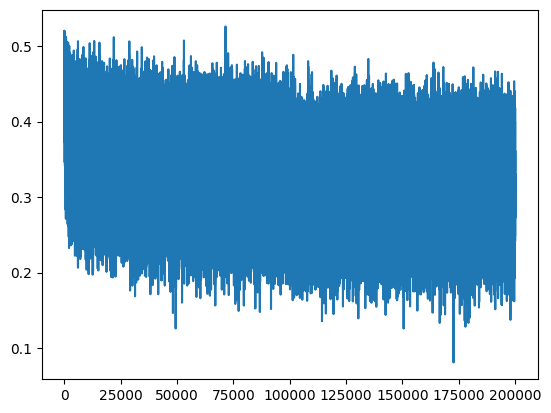

In [109]:
plt.plot(lossi);

In [110]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train':(Xtr, Ytr),
        'val':(Xval, Yval),
        'test': (Xtest, Ytest)
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias     # batchnorm layer
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.052036762237549
val 2.098806381225586


**Other Note:** Batch Normalization introduces its own bias term (bn_bias). Since the normalization step already subtracts the batch mean (removing any existing bias), any bias added in the previous layer becomes redundant. Therefore, there's no need to include a bias term in the layer before BatchNorm, as BatchNorm itself handles the bias adjustment.

# Pytorch-ifying the code

In [120]:
class Linear:
    def __init__(self, fanin, fanout, bias=True):
        self.weight = torch.randn((fanin, fanout), generator=g) / fanin**0.5 # kaiming initilization
        self.bias = torch.zeros(fanout) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [121]:
class BatchNorm:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.beta = torch.zeros(dim)
        self.gamma = torch.ones(dim)

        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)


    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdims=True)
            xvar= x.var(0, keepdims=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x-xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [122]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [123]:
n_embed = 10
n_hidden = 100
block_size = 3
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator = g)
layers = [
    Linear(n_embed* block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm(vocab_size)
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47351


In [124]:
n_iter = 200000
batch_size = 32
lossi = []
ud = []  # update to data

for i in range(n_iter):
    # mini batch contruct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()

    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10000==0:
        print(f'{i:7d}/{n_iter:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

      0/ 200000:3.3146
  10000/ 200000:2.1791
  20000/ 200000:2.1720
  30000/ 200000:2.1325
  40000/ 200000:2.1216
  50000/ 200000:2.4034
  60000/ 200000:2.0538
  70000/ 200000:1.8628
  80000/ 200000:1.8452
  90000/ 200000:1.7238
 100000/ 200000:1.9723
 110000/ 200000:2.4773
 120000/ 200000:1.8988
 130000/ 200000:1.9877
 140000/ 200000:2.1475
 150000/ 200000:2.2336
 160000/ 200000:1.8702
 170000/ 200000:1.9208
 180000/ 200000:2.2749
 190000/ 200000:2.2126


In [129]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xtest, Ytest),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.9944698810577393
val 2.0830743312835693


# **EXTRA**
These are some useful distributions to check out while training neural networks suggested by Karpathy

**Activation Distribution**

Shows how activations are spread across layers.
We wanna see if values are centered around 0 and have a decent spread (std ~1).
If most activations are stuck near -1 or 1 (for tanh), that means neurons are saturated → gradients will start dying.

**Gradient Distribution**

Plots how the gradients of activations look.
Ideally, they shouldn’t all be tiny or blowing up.
If most gradients are near zero → vanishing gradients.
If they’re huge → exploding gradients.
Basically shows how well the signal flows backward.

**Weight Gradient Distribution**

This one shows gradients of weights + prints grad:data ratio.
A good ratio is around 1e-3, meaning updates are small but effective.
If the ratio’s way lower → learning too slow.
If it’s way higher → updates are too big and unstable.

**Grad-to-Data Ratio Over Time**

Tracks that grad:data ratio as training goes on.
You wanna see those lines roughly around the 1e-3 mark.
If it drifts too high or too low, that’s usually a sign to tweak the learning rate or weight init.

layer 1 (      Tanh): mean -0.05, std 0.89, saturated: 54.88%
layer 4 (      Tanh): mean +0.02, std 0.72, saturated: 18.97%
layer 7 (      Tanh): mean -0.02, std 0.76, saturated: 19.44%
layer 10 (      Tanh): mean +0.01, std 0.78, saturated: 20.59%
layer 13 (      Tanh): mean -0.05, std 0.80, saturated: 21.59%


Text(0.5, 1.0, 'activation distribution')

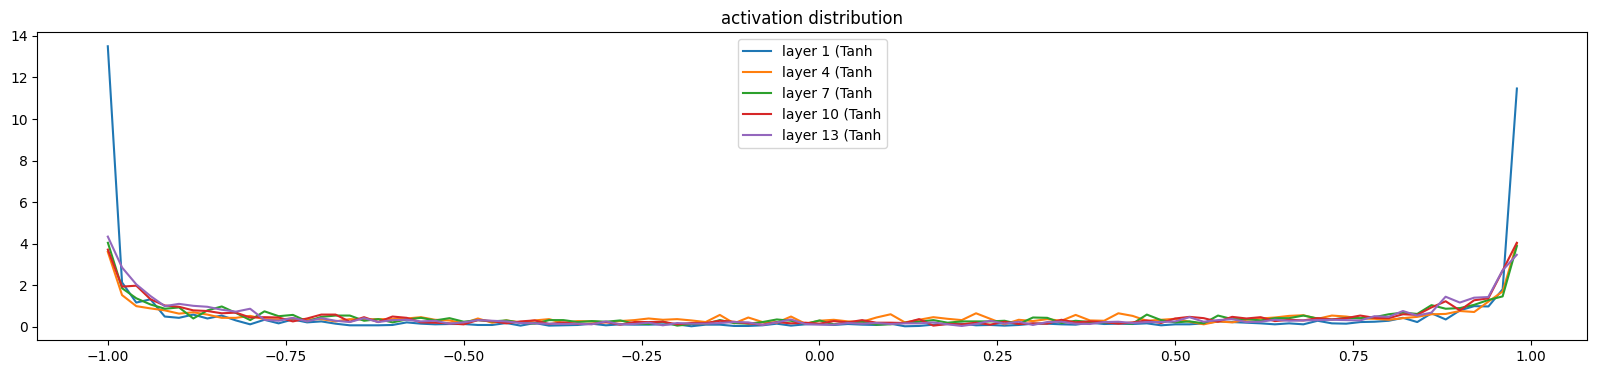

In [125]:
# visualize histograms of activations
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.000000, std 4.500705e-03
layer 4 (      Tanh): mean -0.000000, std 3.532746e-03
layer 7 (      Tanh): mean -0.000000, std 3.194176e-03
layer 10 (      Tanh): mean -0.000000, std 3.045817e-03
layer 13 (      Tanh): mean +0.000000, std 3.440925e-03


Text(0.5, 1.0, 'gradient distribution')

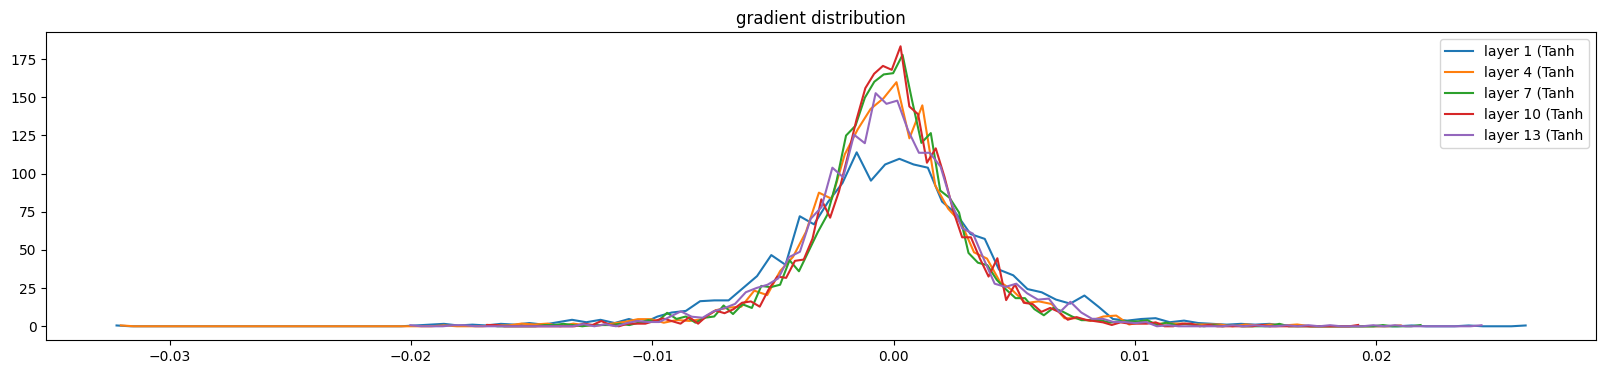

In [126]:
# visualize histograms of gradients
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.002069 | std 1.665937e-02 | grad:data ratio 1.318678e-02
weight  (30, 100) | mean -0.000055 | std 1.120414e-02 | grad:data ratio 2.422850e-02
weight (100, 100) | mean +0.000002 | std 6.851351e-03 | grad:data ratio 2.615946e-02
weight (100, 100) | mean +0.000058 | std 5.732136e-03 | grad:data ratio 2.449045e-02
weight (100, 100) | mean -0.000006 | std 5.237818e-03 | grad:data ratio 2.345308e-02
weight (100, 100) | mean -0.000003 | std 4.721761e-03 | grad:data ratio 2.221221e-02
weight  (100, 27) | mean -0.000118 | std 7.910496e-03 | grad:data ratio 2.266986e-02


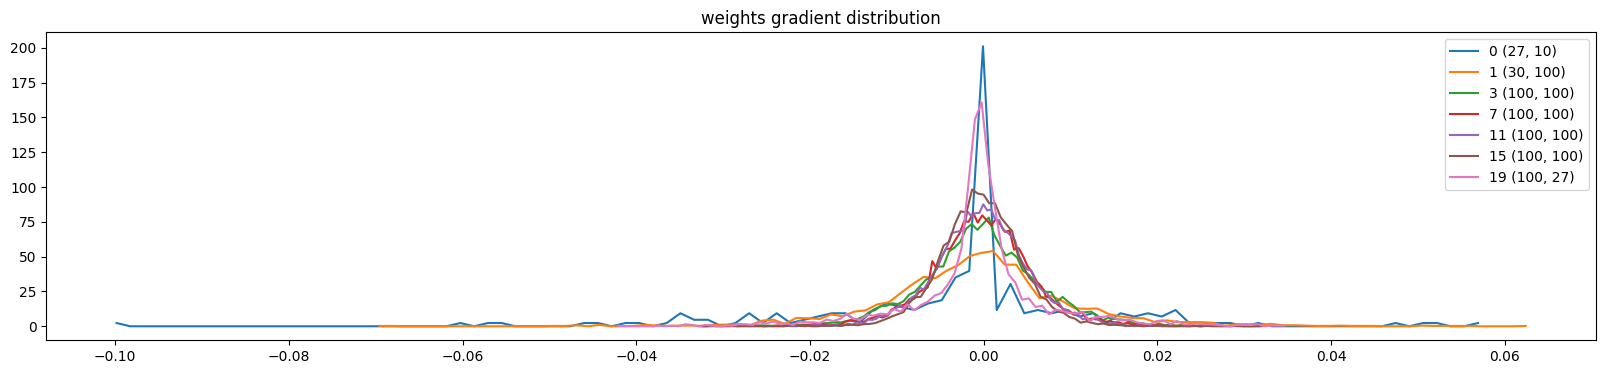

In [127]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


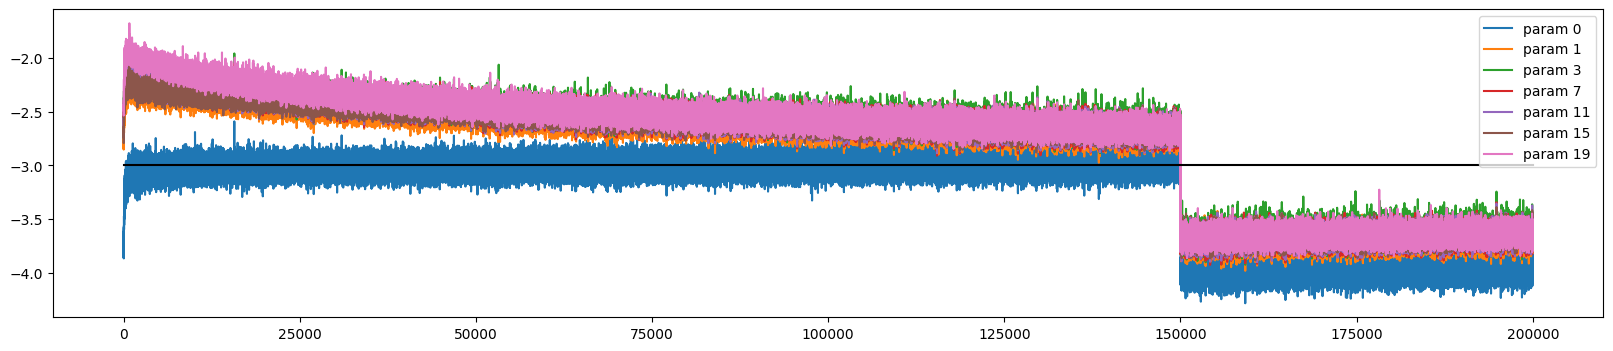

In [128]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);